# 量子特徴量マップとカーネル

このページでは、量子[特徴量マップ](gloss:feature-map)と[カーネル](gloss:kernel)について詳しく説明します。分類アルゴリズムで使用した後に、カーネルアライメントを紹介の後、現在の最先端技術について説明します。

## はじめに

機械学習の一般的なタスクは、データのパターンを見つけて学習することです。多くの機械学習アルゴリズムは、カーネル関数を使用して入力データセットを高次元の特徴空間にマッピングします。

$$ k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle $$

ここで、$k$はカーネル関数、$\vec{x}_i, \vec{x}_j$は $n$ 次元入力、$f$は $n$ 次元から$m$次元空間へのマッピングです。$\langle a,b \rangle$は内積を示します。有限データの場合、カーネル関数は行列として表すことができます。

$$
\cssId{_k-sub-ij}{K_{ij}} = k(\vec{x}_i,\vec{x}_j)
$$

データセットをより高次元の特徴空間にマッピングする考え方を、2次元平面に大きな円の中に小さな円を含んだ[円のデータセット](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html)を使用して、お見せしましょう。

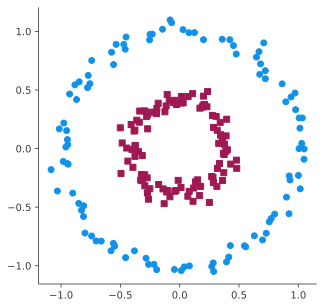

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles

# Create circles dataset
X, Y = make_circles(n_samples=200, noise=0.05, factor=0.4)

# Separate smaller and larger circles
A = X[np.where(Y==0)]
B = X[np.where(Y==1)]

# Plot in 2D
plt.figure(figsize=(5,5))
plt.scatter(A[:,0],A[:,1], marker='o')
plt.scatter(B[:,0],B[:,1], marker='s', c='C3')
plt.show()

データセットを見ると、構造があることは明らかですが、2つの円は2次元では線形分離可能ではありません。データを3次元$z = x^2 + y^2$に変換してみましょう。

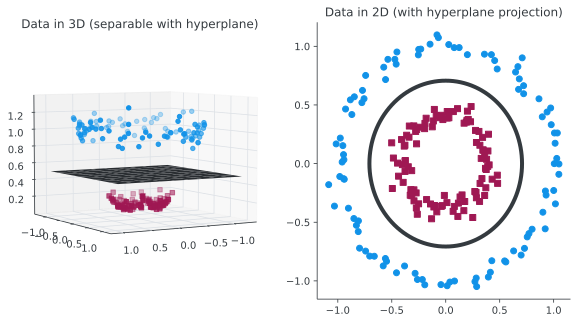

In [2]:
def transform_function(x, y):
    """ Implements f(x,y) = [x, y, z = x^2 + y^2] """
    # pylint: disable=invalid-name
    return np.array([x, y, x**2.0 + y**2.0])

# Transform
A1 = np.array([transform_function(x, y) for
               x, y in zip(np.ravel(A[:,0]), np.ravel(A[:,1]))])
B1 = np.array([transform_function(x, y)
               for x, y in zip(np.ravel(B[:,0]), np.ravel(B[:,1]))])

# Plot in 3D
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Data in 3D (separable with hyperplane)")
ax.scatter(A1[:,0], A1[:,1], A1[:,2], marker='o')
ax.scatter(B1[:,0], B1[:,1], B1[:,2], marker='s', c='C3')  # make red
ax.view_init(5, 60)
x = np.arange(-1.25, 1.25, 0.25)
y = np.arange(-1.25, 1.25, 0.26)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z[:,:] = 0.5
ax.plot_surface(X, Y, Z, color='#343A3F')

# Project data to 2D
ax2d = fig.add_subplot(122)
ax2d.set_title("Data in 2D (with hyperplane projection)")
ax2d.scatter(A1[:,0], A1[:,1], marker='o')
ax2d.scatter(B1[:,0], B1[:,1], marker='s',
            c='C3')  # make red
ax2d.add_patch(pl.Circle((0,0), radius=np.sqrt(0.5),
               fill=False, linestyle='solid', linewidth=4.0,
               color='#343A3F'))
plt.show()

上記のように、3次元ではデータは$z = 0.5$の[超平面](gloss:hyperplane)によって分離可能であり、データを2次元に投影するとこの超平面は[非線形](gloss:nonlinear)になります。

## 量子特徴量マップ

量子機械学習では、量子特徴量マップ$\phi(\vec{x})$は、古典特徴量ベクトル$\vec{x}$を量子ヒルベルト空間$| \phi(\vec{x})\rangle \langle \phi(\vec{x})|$にマップします。量子特徴量マップはユニタリ変換$\vec{U_\phi}(\vec{x})$を使用して$\vec{x} \rightarrow | \phi(\vec{x})\rangle$を変換します。これは通常[パラメーター化された量子回路](./parameterized-quantum-circuits)です。

パラメーター化された量子回路に基づいて古典シミュレーションが難しい量子特徴量マップを構築することは、古典機械学習アプローチよりも有利になる可能性を獲得するための重要なステップであり、現在の研究が活発な分野です。

参考文献1で、著者は古典的にシミュレートするのが難しいと[推測](gloss:conjecture)され、かつ[近い将来の量子デバイス](gloss:near-term-quantum-devices)上で[深さの短い](gloss:short-depth)回路として実装できる量子特徴量マップの種類を提唱しています。Qiskitはこれらを[`PauliFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html)として実装します。深さ$d$の量子特徴量マップは、ユニタリ演算子によって実装されます。

$$ \mathcal{U}_{\Phi(\vec{x})}=\prod_d U_{\Phi(\vec{x})}H^{\otimes n},\ U_{\Phi(\vec{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\vec{x})\prod_{k\in S} P_i\right)$$

これには、[エンタングリング・ブロック](gloss:entangling-blocks) $U_{\Phi(\vec{x})}$でインターリーブされたアダマールゲートの層が含まれ、

$d=2$ の回路図に示すように、古典的なデータをエンコードします。

![](images/kernel/featuremap.svg)

エンタングリング・ブロック内で、 $U_{\Phi(\vec{x})}$: $P_i \in { I, X, Y, Z }$ は[パウリ行列](gloss:pauli-matrices)を表し、インデックス $S$ は異なる量子ビットまたはデータポイント間の接続性を表します: $S \in {\binom{n}{k}\ \mathrm{combinations,\ }k = 1,... n }$。デフォルトでデータマッピング関数 $\phi_S(\vec{x })$ は以下です。

$$\cssId{_map-1}{\phi_S:\vec{x}\mapsto} \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

$k = 2, P_0 = Z, P_1 = ZZ$の場合、これはQiskitの[`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)です。

$$\cssId{_script-u}{\mathcal{U}_{\Phi(\vec{x})}} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\vec{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\vec{x}) \, Z_j\right) \, H^{\otimes n} \right)^d$$

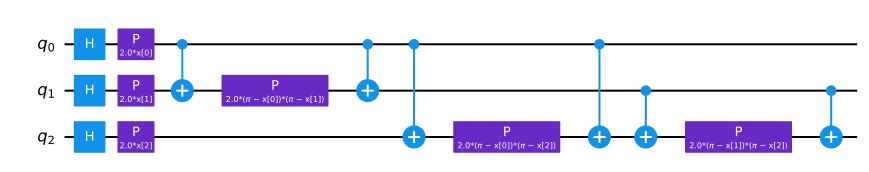

In [3]:
from qiskit.circuit.library import ZZFeatureMap
# 3 features, depth 1
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.decompose().draw()

Qiskit の[`adhoc`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.datasets.ad_hoc_data.html)データセットを見てみましょう。これは、参考文献 1 で使用されている`ZZFeatureMap`からサンプリングされた 2 つのクラスのデータセットであり、各クラスから2つの特徴量の20個のトレーニングデータポイントと5個のテストデータポイントを作成します。

In [4]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 12345

from qiskit_machine_learning.datasets import ad_hoc_data
train_data, train_labels, test_data, test_labels, sample_total = (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3,
                include_sample_total=True, one_hot=False))

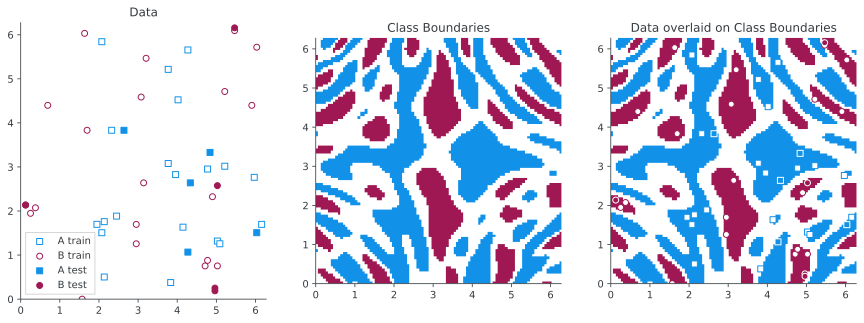

In [5]:
# Plot data and class boundaries
fig = plt.figure(figsize=(15, 5))
axdata = fig.add_subplot(131)
axdata.set_title("Data")
axdata.set_ylim(0, 2 * np.pi)
axdata.set_xlim(0, 2 * np.pi)
plt.scatter(train_data[np.where(train_labels[:] == 0), 0],
            train_data[np.where(train_labels[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='C0',
            label="A train")
plt.scatter(train_data[np.where(train_labels[:] == 1), 0],
            train_data[np.where(train_labels[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='C3',
            label="B train")
plt.scatter(test_data[np.where(test_labels[:] == 0), 0],
            test_data[np.where(test_labels[:] == 0), 1],
            marker='s', facecolors='C0', label="A test")
plt.scatter(test_data[np.where(test_labels[:] == 1), 0],
            test_data[np.where(test_labels[:] == 1), 1],
            marker='o', facecolors='C3', label="B test")
plt.legend()

from matplotlib.colors import ListedColormap
cmap = ListedColormap(["C3","w","C0"])
axmap = fig.add_subplot(132)
axmap.set_title("Class Boundaries")
axmap.set_ylim(0, 2 * np.pi)
axmap.set_xlim(0, 2 * np.pi)
axmap.imshow(np.asmatrix(sample_total).T,
             interpolation='nearest',
             origin='lower', cmap=cmap,
             extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth = fig.add_subplot(133)
axboth.set_title("Data overlaid on Class Boundaries")
axboth.set_ylim(0, 2 * np.pi)
axboth.set_xlim(0, 2 * np.pi)
axboth.imshow(np.asmatrix(sample_total).T, interpolation='nearest',
              origin='lower', cmap=cmap,
              extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth.scatter(train_data[np.where(train_labels[:] == 0), 0],
               train_data[np.where(train_labels[:] == 0), 1],
               marker='s', facecolors='w', edgecolors='C0', label="A")
axboth.scatter(train_data[np.where(train_labels[:] == 1), 0],
               train_data[np.where(train_labels[:] == 1), 1],
               marker='o', facecolors='w', edgecolors='C3', label="B")
axboth.scatter(test_data[np.where(test_labels[:] == 0), 0],
               test_data[np.where(test_labels[:] == 0), 1],
               marker='s', facecolors='C0', edgecolors='w',
               label="A test")
axboth.scatter(test_data[np.where(test_labels[:] == 1), 0],
               test_data[np.where(test_labels[:] == 1), 1],
               marker='o', facecolors='C3', edgecolors='w',
               label="B test")
plt.show()

左上には、 `adhoc`データセットの各クラスからの 25個の 2 次元データ ポイントが表示されます。どのデータ ポイントがどのクラスに属しているかについて明確なパターンがないことに注目してください。上の中央は、データセットの作成に使用された`ZZFeatureMap`によって記述された 16 次元 (実際には 15 次元) の特徴空間の 2 次元射影であり、2 次元でのクラス境界がいかに複雑であるかを示しています。右側には、クラス境界に重ねられたデータ ポイントが表示されています。

## 量子カーネル

量子特徴量マップ$\phi(\vec{x})$は、自然と量子カーネル$k(\vec{x}_i,\vec{x}_j)= \phi(\vec{x}_j)^\dagger\phi(\vec{x}_i)$を導き出します。これは類似性の尺度と考えることができ、$k(\vec{x}_i,\vec{x}_j)$は、$\vec{x}_i$ と $\vec{x}_j$ が近い場合に大きくなります。

有限データを考える場合、量子カーネルを行列として表すことができます。

$K_{ij} = \left| \langle \phi^\dagger(\vec{x}_j)| \phi(\vec{x}_i) \rangle \right|^{2}$<br>遷移振幅を計算することにより、量子コンピューターでこのカーネル行列の各要素を計算できます。

$$
\left| \langle \phi^\dagger(\vec{x}_j)| \phi(\vec{x}_i) \rangle \right|^{2} =
\left| \langle 0^{\otimes n} | U^\dagger_{\phi(\vec{x}_j)} U^\phantom{\dagger}_{\phi(\vec{x}_i)} | 0^{\otimes n} \rangle \right|^{2}
$$

特徴量マップが[パラメーター化された量子回路](./parameterized-quantum-circuits)であると仮定すると、これは $n$ 量子ビットのユニタリー変換 $U_\phi(\vec{x})$ として説明できます。これにより、サポートベクター分類などのカーネル機械学習アルゴリズムで使用できる量子カーネル行列の推定値が得られます。

前に作成した`adhoc`データセットのトレーニング データ ポイントのカーネル行列を解析的に計算してプロットしてみましょう。特徴量マップについては、2 つの特徴量に対して[`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)を 2 回繰り返して使用します。ここでの`calculate_kernel`関数は、Qiskit <a><code>QuantumKernel</code></a>クラスの`evaluate`関数の単純なバージョンであることに注意してください。

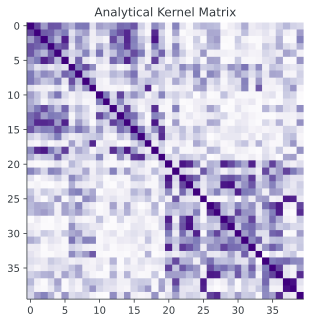

In [6]:
from qiskit import opflow
def calculate_kernel(feature_map, x_data, y_data=None):
    """
        Calculates  kernel matrix from provided feature map and
        dataset(s), x & (y). If y isn't given, self inner product
        of x is calculated.
        No error checking is performed, feature map and datasets
        assumed to have the same dimension
    """
    if y_data is None:
        y_data = x_data
    # Use Operator Flow to create a list of feature map circuits,
    # parameterized by each data point
    x_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(x_data).tolist()))
        )
    y_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(y_data).tolist()))
        )
    # Compute the square of the conjugate inner product of the feature
    # map circuits: the kernel matrix
    kernel = np.abs(
        (~y_circuits.to_matrix_op() @ x_circuits.to_matrix_op()).eval()
    )**2
    return kernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
kernel = calculate_kernel(adhoc_feature_map, train_data)
plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(kernel),interpolation='nearest', origin='upper')
plt.title("Analytical Kernel Matrix")
plt.show()

カーネル行列について注意すべき点がいくつかあります。

1. 各行/列は、データセット内の他のすべてのデータ ポイントとともに、単一のデータポイントの遷移振幅を表します
2. 自分自身へのデータポイントの遷移振幅は 1 であるため、行列は対角が1です。
3. 行列は対称であり、$x \rightarrow y$の遷移振幅は$y \rightarrow x$と同じです

## 量子サポートベクター分類

冒頭で述べたように、多くの機械学習アルゴリズムはカーネル関数を使用して入力データセットをより高次元の特徴空間にマッピングします。よく知られているサポートベクターマシン分類アルゴリズムはその1つです。サポートベクター分類アルゴリズムの詳細については、 [`scikit-learn`ユーザーガイドを](https://scikit-learn.org/stable/modules/svm.html)参照してください。

サポートベクターマシンは特徴空間に超平面を構築します。これは、分類、回帰、またはその他のタスクに使用できます。分類の場合、超平面は、理想的には任意のクラスの最も近いトレーニングデータポイントまでの距離が最大です。次の図は、「*サポートベクター*」と呼ばれるクラス境界上に 3 つのサンプルがある線形分離可能な問題の決定関数を示しています。

参考文献1および2で紹介されているように、量子カーネルサポートベクター分類アルゴリズムは次の手順で構成されています。

![](images/kernel/qsvc.svg)

1. 学習を行い量子カーネル行列をテストします。
    1. 学習用データセット `{latex}\vec{x}_{i},\vec{x}_j` のデータポイントの各ペアに対して、特徴量マップを適用し、遷移確率を測定します: `{latex} K_{ij} = \left| \langle 0 | U^\dagger_{\Phi(\vec{x}_j)} U^\phantom{\dagger}_{\Phi(\vec{x}_i)} | 0 \rangle \right|^2 `.
    2. 学習用データポイント `{latex}\vec{x}_i` とテストポイント `{latex}\vec{y}_i` のそれぞれに対して、特徴量マップを適用し、遷移確率を測定します: `{latex} K_{ij} = \left| \langle 0 | U^\dagger_{\Phi(\vec{y}_i)} U^\phantom{\dagger}_{\Phi(\vec{x}_i)} | 0 \rangle \right|^2 `.
2. 従来のサポートベクターマシン分類アルゴリズムにおいて、量子カーネル行列を使用して学習およびテストを行います。

前に生成した`adhoc`データセットに対して、量子カーネルサポートベクター分類アルゴリズムを実行してみましょう。このデータセットは、 `depth = 2` 、 `dimension = 2`の`ZZFeatureMap`から作成され、2クラスで構成され、各クラスから20 のトレーニングデータポイントと 5 つのテストデータポイントを持つデータで構成されていたことを思い出してください。

まず、前述の`calculate_kernel`関数を使用して、量子カーネル行列の学習とテストをしましょう。

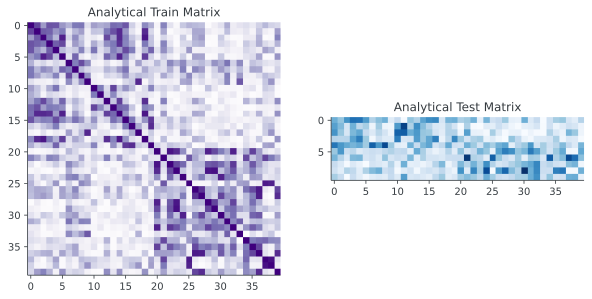

In [7]:
train_kernel = calculate_kernel(adhoc_feature_map, train_data)
test_kernel = calculate_kernel(adhoc_feature_map, train_data, test_data)
# plot analytical matrices
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.asmatrix(train_kernel), interpolation='nearest',
              origin='upper')
axs[0].set_title("Analytical Train Matrix")
axs[1].imshow(np.asmatrix(test_kernel), interpolation='nearest',
              origin='upper', cmap='Blues')
axs[1].set_title("Analytical Test Matrix")
plt.show()

それでは、 `scikit-learn` `svc`アルゴリズムでそれらを使用しましょう。

In [8]:
from sklearn.svm import SVC
# train scikit-learn svm model
model = SVC(kernel='precomputed')
model.fit(train_kernel, train_labels)
print("Number of support vectors for each class:",model.n_support_)
print("Indices of support vectors:", model.support_)

Number of support vectors for each class: [ 9 10]
Indices of support vectors: [ 3  6  7  8  9 11 12 17 19 21 22 24 25 26 27 31 33 38 39]


サポートベクターマシンは特徴量空間で超平面を構築することを思い出してください。分類のために、理想的には超平面は任意のクラスの最も近いトレーニングデータポイントまでの距離が最大になります。各クラスの分離超平面に最も近いトレーニングデータポイントは、「サポートベクター」と呼ばれます。ここで、 `scikit-learn` の`svc`アルゴリズムは、各クラスから 20個ずつのデータポイントを持つトレーニング データセットから、最初のクラスのサポートベクトルを9個、 2 番目のクラスのサポートベクトルを10個特定したことになります。

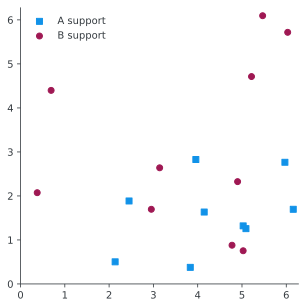

In [9]:
# Plot support vectors
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.scatter(train_data[model.support_[0:model.n_support_[0]], 0],
            train_data[model.support_[0:model.n_support_[0]], 1],
            marker='s', label="A support")
plt.scatter(train_data[model.support_[model.n_support_[0]:], 0],
            train_data[model.support_[model.n_support_[0]:], 1],
            marker='o', c='C3', label="B support")
plt.legend(loc='upper left', frameon=False)
plt.show()

In [10]:
# test svm model
model.score(test_kernel, test_labels)

1.0

トレーニングデータポイントとテストデータポイントは、量子カーネルサポートベクター分類アルゴリズムで使用されるのと同じ特徴量マップを使用して生成されたため、テストデータポイントを完全に分類できることがわかります。これは、ハードウェアを使用する場合にはノイズのために当てはまらない可能性があり、実際のデータセットには当てはまらない可能性があります。

### Qiskitでの実装

Qiskitには[`QuantumKernel`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.QuantumKernel.html)クラスが含まれており、 `scikit-learn` `svc`アルゴリズムから直接利用できます。同じデータセットを使った場合の方法は次のとおりです。

In [11]:
from qiskit import BasicAer
from qiskit_machine_learning.kernels import QuantumKernel
# Create the quantum feature map
adhoc_feature_map = ZZFeatureMap(feature_dimension=2,
                                 reps=2,
                                 entanglement='linear')
# Create the quantum kernel
adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map,
                             quantum_instance=BasicAer.get_backend(
                                             'statevector_simulator'))

# Set the SVC algorithm to use our custom kernel
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(train_data, train_labels)
adhoc_svc.score(test_data, test_labels)

1.0

## 量子カーネルアラインメント

これまで見てきたすべての特徴量マップ (データ エンコーディング) 回路には、トレーニング可能なパラメーターが含まれていません。回路内のすべてのパラメーターは、エンコードされるデータによって定義されます。量子特徴量マップには、参照 3 および 4 で説明されているように、カーネルアライメントと呼ばれる手法を使用して最適化できる変分パラメーターを含めることができ、 [Qiskit Runtime チュートリアルにある量子カーネルアライメント](https://qiskit.org/documentation/partners/qiskit_runtime/tutorials/qka.html)で説明されています。これは、[古典の機械学習](https://link.springer.com/article/10.1007%2Fs10462-012-9369-4)におけるカーネルアライメントに似ています。

## 量子カーネル機械学習

これまで見てきたように、量子カーネルメソッドは、機械学習で量子プロセッサーを使用する方法を提供します。最も普及している量子カーネルアルゴリズムは、2019 年に参考文献 1 および 2 によって導入された量子カーネルサポートベクター マシン (QKSVM) であり、それ以来詳細に研究されてきました。特に:

- 参考文献1では、カーネルベースの訓練がより少ない量子計算で、変分回路の訓練よりも優れた、または同等の量子モデルを見つけることが示されています。

- 参考文献5では、QKSVMは特定の入力データクラスに対して古典手法よりも高速化することが証明されています。

- 参考文献6では、QKSVMを使用して量子機械学習アルゴリズムのデータの計算能力を定量化し、量子モデルが古典モデルを上回ることができる条件を解明しています。

- 参考文献7では、効果的な量子カーネルアラインメントを可能にする量子メトリック学習と呼ばれる手法が紹介されています。

量子カーネルは、分類だけでなく他の機械学習タスクにも使用できます。量子カーネルを使用したクラスタリングの例については、 [Qiskit 量子カーネル機械学習 チュートリアル](https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html)を参照してください。

## 参考文献

1. Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav  Kandala, Jerry M. Chow and Jay M. Gambetta, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209-212 (2019), [doi.org:10.1038/s41586-019-0980-2](https://doi.org/10.1038/s41586-019-0980-2), [arXiv:1804.11326](https://arxiv.org/abs/1804.11326).
2. Maria Schuld and Nathan Killoran, *Quantum machine learning in feature Hilbert spaces*, Phys. Rev. Lett. 122, 040504 (2019), [doi.org:10.1103/PhysRevLett.122.040504](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.040504), [arXiv:1803.07128](https://arxiv.org/abs/1803.07128).
3. Jennifer R. Glick, Tanvi P. Gujarati, Antonio D. Corcoles, Youngseok Kim, Abhinav Kandala, Jay M. Gambetta and Kristan Temme, *Covariant quantum kernels for data with group structure*, [arXiv:2105.03406](https://arxiv.org/abs/2105.03406)
4. Thomas Hubregtsen, David Wierichs, Elies Gil-Fuster, Peter-Jan H. S. Derks, Paul K. Faehrmann and Johannes Jakob Meyer, *Training Quantum Embedding Kernels on Near-Term Quantum Computers*, [arXiv:2105.02276](https://arxiv.org/abs/2105.02276)
5. Yunchao Liu, Srinivasan Arunachalam and Kristan Temme, *A rigorous and robust quantum speed-up in supervised machine learning* (2020), [arXiv:2010.02174](https://arxiv.org/abs/2010.02174).
6. Hsin-Yuan Huang, Michael Broughton, Masoud Mohseni, Ryan Babbush, Sergio Boixo, Hartmut Neven and Jarrod R. McClean, *Power of data in quantum machine learning* (2020), [arXiv:2011.01938](https://arxiv.org/abs/2011.01938).
7. Lloyd, Seth, Maria Schuld, Aroosa Ijaz, Josh Izaac, and Nathan Killoran. "Quantum embeddings for machine learning." *arXiv preprint available at [arXiv:2001.03622](https://arxiv.org/abs/2001.03622)* (2020).

In [12]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table